# KindleUnlimited Title Analysis

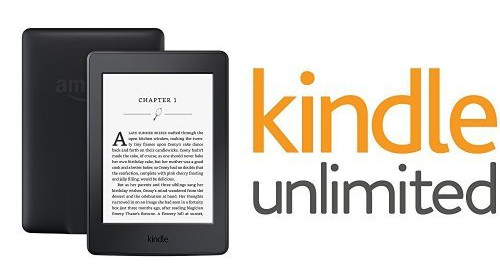

## Introduction

In this notebook, I assess performance data for titles that have been on Amazon's subscription program KindleUnlimited (KU for short). My goal was to explore the data, find the 3 below items and then to give data-based recommendations to the KU business team.

1. The 5 titles with the highest daily borrow rate from April 1, 2019 through June 30, 2019 and their borrow rates.

2. The mean and standard deviation of daily borrow rates for titles active in Prime Reading vs. the mean and standard deviation for ones not active in Prime Reading and determining if the difference is significant.

3. The relationship betweeen genre and daily borrow rates

Please see the end of the notebook for the final results and my business recommendations.

## The Data

I was given two csv files, which I import and interpret below. There are over 2900 titles across 4 genres, with data from April 1st, 2018 and June 30th 2019.

###  Dataset Interpretability

A borrow is a book read through the KU program, while a sale is a book purchased on Amazon. Most titles are only on the platform quarterly but others are on for multiple quarters. I define quarter as 3 month segments starting in January.

For each title, there is different supporting data:

    1. whether the title was simultaneously in Prime Reading during the quarter of participation
    2. average sales on Amazon for the previous 90 days immediately before starting in KU
    3. the genre
    4. the first and last day of participation on KU

In [58]:
# import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from scipy.stats import f_oneway

%matplotlib inline

### Data Preprocessing

In [2]:
# import csv's into dataframes

borrows = pd.read_csv('data_science_challenge_ku_borrows[3][1][2][2].csv')
titles_data = pd.read_csv('data_science_challenge_ku_titles_data[3][1][2][1].csv')

#print headers

print('1st dataset: KU Borrows')


print(borrows.head())

print('2nd dataset: Title Information')
titles_data.head()

1st dataset: KU Borrows
   title_id     Date  ku_borrows
0         0  4/21/18         3.0
1         0  4/22/18         6.0
2         0  4/23/18         1.0
3         0  4/24/18         0.0
4         0  4/25/18         3.0
2nd dataset: Title Information


,title_id,quarter_start_date,first_day_in_KU,last_day_in_KU,avg_units_sold_in_preceding_90_days,active_in_prime_reading,genre
0,0,4/1/18,4/1/18,6/30/19,1.422222,0,nonfiction
1,0,7/1/18,4/1/18,6/30/19,1.145455,1,nonfiction
2,0,10/1/18,4/1/18,6/30/19,0.855556,1,nonfiction
3,0,1/1/19,4/1/18,6/30/19,0.755556,1,nonfiction
4,0,4/1/19,4/1/18,6/30/19,0.600000,1,nonfiction


In [3]:
#display info

print(borrows.info())
print(titles_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222942 entries, 0 to 222941
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   title_id    222942 non-null  int64  
 1   Date        222942 non-null  object 
 2   ku_borrows  222932 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   title_id                             2905 non-null   int64  
 1   quarter_start_date                   2905 non-null   object 
 2   first_day_in_KU                      2905 non-null   object 
 3   last_day_in_KU                       2905 non-null   object 
 4   avg_units_sold_in_preceding_90_days  2902 non-null   float64
 5   active_in_prime_reading              290

In [4]:
#convert dates from object to datetime

borrows['Date'] = pd.to_datetime(borrows.Date,format = '%m/%d/%y', errors = 'coerce')

titles_data['quarter_start_date'] = pd.to_datetime(titles_data.quarter_start_date, format = '%m/%d/%y',errors = 'coerce')
titles_data['first_day_in_KU'] = pd.to_datetime(titles_data.first_day_in_KU,format = '%m/%d/%y',errors = 'coerce')
titles_data['last_day_in_KU'] = pd.to_datetime(titles_data.last_day_in_KU,format = '%m/%d/%y',errors = 'coerce')

In [5]:
#verify type of date columns is now datetime

print(type(borrows['Date']))

#count number of errors by NaT

print("Borrows invalid dates #:", borrows['Date'].isna().value_counts())
print("Quarter_start_date invalid dates #:", titles_data['quarter_start_date'].isna().value_counts())
print("first_day_in_KU invalid dates #:", titles_data['first_day_in_KU'].isna().value_counts())
print("last_day_in_KU invalid dates #:", titles_data['last_day_in_KU'].isna().value_counts())

<class 'pandas.core.series.Series'>
Borrows invalid dates #: False    222933
True          9
Name: Date, dtype: int64
Quarter_start_date invalid dates #: False    2904
True        1
Name: quarter_start_date, dtype: int64
first_day_in_KU invalid dates #: False    2905
Name: first_day_in_KU, dtype: int64
last_day_in_KU invalid dates #: False    2903
True        2
Name: last_day_in_KU, dtype: int64


In [6]:
#drop null titles and null values

borrows['Date'].dropna(inplace= True)
titles_data['quarter_start_date'].dropna(inplace=True)
titles_data['first_day_in_KU'].dropna(inplace=True)
titles_data['last_day_in_KU'].dropna(inplace=True)

# #1. Finding the Titles with the Highest Daily Borrow Rates

In [7]:
# parse dates to only range of interest

df = borrows.loc[(borrows.Date < '2019-07-01') & (borrows.Date > '2019-03-31')]

#confirm dates range from 2019-04-01 to 2019-06-30
print(df.Date.min(), df.Date.max())

2019-04-01 00:00:00 2019-06-30 00:00:00


In [8]:
#group by titles, take avg daily borrow rate for each, sort by descending to find top 5

df.groupby('title_id').mean().sort_values('ku_borrows',ascending=False).head()

,ku_borrows
title_id,
670,280.959184
1576,127.462963
1575,112.870370
1577,110.822222
118,103.175824


From the above, we can see the top 5 title daily borrow averages are title_id's 670, 1576, 1575, 1577, and 118. We organized the mean daily borrows during the period in descending order.

# #2. Comparing Impact of Amazon Prime on Title Borrows

To compare daily average borrow rates across the dataset, I will merge the two datasets once I group by title. I will then split the dataset into two dataframes by whether they are Prime Reading or not. I will then calculate the means and standard deviation of daily borrow rates for each dataframe and then perform a t-test to see if the means and standard deviations are significantly different from each other.  

Amazon Prime titles are available to rent for free for Prime subscribers. Since a lot of KindleUnlimited users are Amazon Prime subscribers, I hypothesize that books available on both Prime and KU will be less borrowed on KU.

Given that many titles have multiple quarters available on KU where their availability on Prime Reading changes, I first limited the question to a single quarter, Q2 of 2019 as above, to help solve the problem. In the second part of this question, I expand to all quarters of data.

## Q2 of 2019

In [9]:
# create daily borrow rate, indexed by title with 2019Q2 data

df1 = pd.DataFrame(df.groupby('title_id').mean())

#limit titles_data by dates

df2 = titles_data.loc[(titles_data.quarter_start_date == '2019-04-01')]

# set df2 index as title_id
df2.set_index('title_id',inplace= True)
#merge df's

q2_data = pd.merge(df1,df2,left_index=True,right_index=True)


q2_data.head()

,ku_borrows,quarter_start_date,first_day_in_KU,last_day_in_KU,avg_units_sold_in_preceding_90_days,active_in_prime_reading,genre
title_id,,,,,,,
0,4.120879,2019-04-01,2018-04-01,2019-06-30,0.600000,1,nonfiction
1,17.010989,2019-04-01,2018-11-01,2019-06-30,1.833333,1,nonfiction
2,3.045977,2019-04-01,2019-04-01,2019-06-30,1.092105,0,nonfiction
3,1.012195,2019-04-01,2019-04-01,2019-06-30,0.413333,0,nonfiction
4,1.258824,2019-04-01,2019-04-01,2019-06-30,0.122222,0,nonfiction


In [10]:
#calculate mean borrows for titles in prime reading

prime_titles_q2 = q2_data.loc[q2_data.active_in_prime_reading == 1]

prime_mean_q2 = prime_titles_q2.ku_borrows.mean()

#calculate std dev
prime_std_q2 = prime_titles_q2.ku_borrows.std()

print("Prime Titles' mean daily borrows in Q2 2019: ", prime_mean_q2)
print("Prime Titles' standard deviation of daily borrows in Q2 2019: ", prime_std_q2)

Prime Titles' mean daily borrows in Q2 2019:  9.383078744537364
Prime Titles' standard deviation of daily borrows in Q2 2019:  28.681047571358096


In [11]:
#create non-prime df
nonprime_titles_q2 = q2_data.loc[q2_data.active_in_prime_reading == 0]

#calculate mean for non-prime
nonprime_mean_q2 = nonprime_titles_q2.ku_borrows.mean()

#calculate std for non-prime
nonprime_std_q2 = nonprime_titles_q2.ku_borrows.std()

print("Non-Prime Titles' mean daily borrows in Q2 2019: ", nonprime_mean_q2)
print("Non-Prime Titles' standard deviation of daily borrows in Q2 2019: ", nonprime_std_q2)

Non-Prime Titles' mean daily borrows in Q2 2019:  1.4255961719107788
Non-Prime Titles' standard deviation of daily borrows in Q2 2019:  1.165285906873064


Above, we see that titles available on Prime Reading are substantially more borrowed on Kindle Unlimited. We do not know if this difference is significant, until we perform a statistical test. We are going to perform a two-tailed t-test since the population standard deviation is not known and the sample size is greater than 30.

The first null hypothesis is the daily borrow rates are from the dataset and the alternative hypothesis is the two means are different. We will reject the null if the p-value is less than 5%. 

In [12]:
# test for significance of mean difference

print(ttest_ind(prime_titles_q2['ku_borrows'], nonprime_titles_q2['ku_borrows']))

Ttest_indResult(statistic=7.699162301437614, pvalue=3.47858762838086e-14)


The p-value is less than .05 which indicates that the two samples are from different populations. We can thus conclude the means are significantly different.

## Across all quarters

Matching titles with the correct quarters and grouping up averages was more challenging. I started by filtering all the data to find each quarters borrows average.

In [13]:
#create df with each titles quarterly performance by mean daily borrows

df1 = pd.DataFrame(borrows.groupby([borrows['title_id'],borrows['Date'].dt.to_period('Q')])['ku_borrows'].agg('mean'))

df1.tail()

ku_borrows
title_id Date              
1577     2018Q2  276.208333
         2018Q3   20.021739
         2018Q4    3.717391
         2019Q1   82.766667
         2019Q2  110.822222

In [14]:
#create new df by grouping up titles_data by title and quarter

df2 = pd.DataFrame(titles_data.groupby([titles_data['title_id'], titles_data['quarter_start_date'].dt.to_period('Q')]).head())

#switch quarter_start_date format to qx20xx
df2['quarter_start_date'] = df2['quarter_start_date'].dt.to_period('Q')

#rename to quarter so df's match
df2.rename({'quarter_start_date':'Date'},axis=1,inplace=True)
df2.head()

,title_id,Date,first_day_in_KU,last_day_in_KU,avg_units_sold_in_preceding_90_days,active_in_prime_reading,genre
0,0,2018Q2,2018-04-01,2019-06-30,1.422222,0,nonfiction
1,0,2018Q3,2018-04-01,2019-06-30,1.145455,1,nonfiction
2,0,2018Q4,2018-04-01,2019-06-30,0.855556,1,nonfiction
3,0,2019Q1,2018-04-01,2019-06-30,0.755556,1,nonfiction
4,0,2019Q2,2018-04-01,2019-06-30,0.600000,1,nonfiction


In [15]:
#inner join on where title_id and quarter are equal

quarterly_df = pd.merge(df1,df2, on=['title_id','Date'], how='inner')

#inspect
quarterly_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   title_id                             2900 non-null   int64         
 1   Date                                 2900 non-null   period[Q-DEC] 
 2   ku_borrows                           2900 non-null   float64       
 3   first_day_in_KU                      2900 non-null   datetime64[ns]
 4   last_day_in_KU                       2898 non-null   datetime64[ns]
 5   avg_units_sold_in_preceding_90_days  2897 non-null   float64       
 6   active_in_prime_reading              2900 non-null   int64         
 7   genre                                2900 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(1), period[Q-DEC](1)
memory usage: 203.9+ KB


In [16]:
#calculate mean and stddev for Prime-titles

prime_mean = quarterly_df[quarterly_df.active_in_prime_reading == 1]['ku_borrows'].mean()

prime_std = quarterly_df[quarterly_df.active_in_prime_reading == 1]['ku_borrows'].std()

print('Mean daily borrows across all Prime-available titles: ' ,prime_mean)
print('Standard deviation of daily borrows across non Prime-available titles: ', prime_std)

Mean daily borrows across all Prime-available titles:  12.426888442167638
Standard deviation of daily borrows across non Prime-available titles:  44.30922628221677


In [17]:
#calculate mean and stddev for non-Prime titles

nonprime_mean = quarterly_df[quarterly_df.active_in_prime_reading == 0]['ku_borrows'].mean()

nonprime_std = quarterly_df[quarterly_df.active_in_prime_reading == 0]['ku_borrows'].std()

print('Mean daily borrows across all Prime-unavailable titles: ' , nonprime_mean)
print('Standard deviation of daily borrows across non Prime-unavailable titles: ', nonprime_std)

Mean daily borrows across all Prime-unavailable titles:  1.9405957955333955
Standard deviation of daily borrows across non Prime-unavailable titles:  7.494682941284685


In [18]:
#test for significance

print(ttest_ind(quarterly_df[quarterly_df.active_in_prime_reading == 1]['ku_borrows'], quarterly_df[quarterly_df.active_in_prime_reading == 0]['ku_borrows']))

Ttest_indResult(statistic=10.882969059719478, pvalue=4.6048480415628644e-27)


The p-value is less than .05, so we can conclude the difference between the two samples is significantly different. We can confidently conclude that if titles are on Prime Reading, they are borrowed at a much higher rate.

# #3. The Impact of Genre on Borrow Rates

We will next examine how genre impacts borrow rates. Fortunately, we have organized all titles by ID and quarter above so the preprocessing steps should be easier.

In [20]:
#show number of titles from each genre

quarterly_df.genre.value_counts()

nonfiction       1657
other fiction     662
kids              304
mystery           277
Name: genre, dtype: int64

In [25]:
#print mean daily borrows per book by genre

quarterly_df.groupby('genre')['ku_borrows'].mean().sort_values(ascending=False)

genre
mystery          6.485649
other fiction    5.047265
kids             3.998471
nonfiction       2.675700
Name: ku_borrows, dtype: float64

In [26]:
#print overall mean

quarterly_df.ku_borrows.mean()

3.7196495824796187

From the above, we can see that genre can have a strong effect on borrowing rates. In particular, mystery and other fiction are the highest borrowed books. We can display this further using graphs. After, we will test the significance of the impact on daily borrow rates as well as quantify the correlation of genre to borrows. 

In [35]:
#create df of means by genre
genre_means = pd.DataFrame(quarterly_df.groupby('genre')['ku_borrows'].mean())
genre_means.head()

,ku_borrows
genre,
kids,3.998471
mystery,6.485649
nonfiction,2.675700
other fiction,5.047265


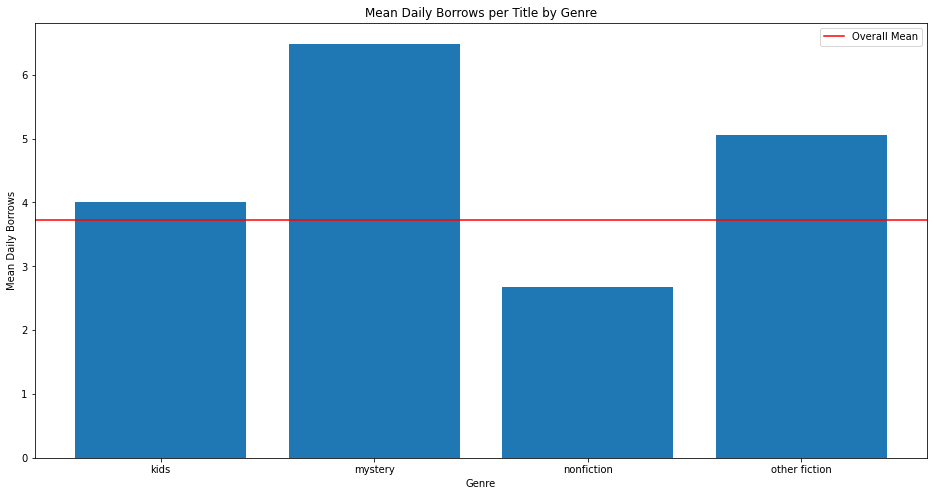

In [73]:
#plot bar graph

fig, ax = plt.subplots(figsize= (16,8))

plt.bar(genre_means.index, genre_means.ku_borrows)
plt.xlabel('Genre')
plt.ylabel('Mean Daily Borrows')
plt.title('Mean Daily Borrows per Title by Genre')
plt.axhline(quarterly_df.ku_borrows.mean(),color='red',label='Overall Mean')
plt.legend()
plt.show();

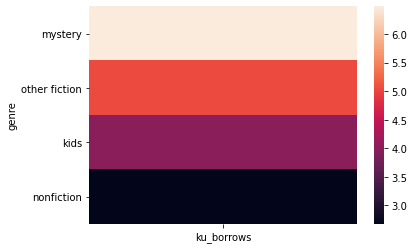

In [53]:
#build seaborn heatmap of ku_borrows vs. genre

sns.heatmap(genre_means.sort_values('ku_borrows',ascending=False));

To quantify the impact genre has on mean daily book sales, we can use a number of statistical methods. Genre is an nominal variable because there are only 4 non-quantitative options. Since we're seeing the impact of a nominal categorical independent variable on a dependent variable, I chose to do an ANOVA test.

The null hypothesis is that genre has no impact on ku_borrows. If the p-value is less than .05, we reject the null and accept the alternative that genre has a significant impact on ku_borrows.

In [67]:
f_oneway(quarterly_df[quarterly_df.genre == 'other fiction']['ku_borrows'],
        quarterly_df[quarterly_df.genre == 'nonfiction']['ku_borrows'],
        quarterly_df[quarterly_df.genre == 'kids']['ku_borrows'],
        quarterly_df[quarterly_df.genre == 'mystery']['ku_borrows'])

F_onewayResult(statistic=4.335601092632563, pvalue=0.004680228847844436)

The p-value is .004, so we reject the null and conclude that genre has a significant impact on the borrowing rate.

# #4. Business Recommendations Based on Results

From the above analysis in sections 2 and 3, I found that titles that were also on Prime Reading were borrowed at a significantly higher rate and that the highest-borrowed genre were mystery novels. Thus, I give the following recommendations:

1. Make more KindleUnlimited titles available on PrimeReading simultaneously. This will drive up borrows and use of the KindleUnlimited service.

2. Increase the amount of mystery novels on KindleUnlimited. Mystery novels were on average borrowed at nearly twice the rate of the average (6.5 vs. 3.7 per day)

3. Focus spending on acquiring fiction books over non-fiction books. Non-fiction books were borrowed at a low rate of 2.7 per day while fiction books were more than double the rate at 5.0. KindleUnlimited readers are overall more likely to be using the service for fiction reading than non-fiction reading.

# Recap of Results

1. The top 5 titles from April 1st to June 30th 2019 were title_id's 670, 1576, 1575, 1577, and 118. 670 was borrowed over 280 times a day on average throughout the period.

2. Titles on prime reading were borrowed at a mean daily rate of 12.4 borrows per day between Q2 2018 and Q2 2019, while titles not on Prime were borrowed 1.94 times a day. The standard deviation for Prime titles and non-Prime titles were 44.3 and 7.5, respectfully. Using a t-test, I confirmed the impact of Prime availability on mean daily borrows was significant.

3. Genre had a significant impact on borrowing rates. The most borrowed genre was mystery, where each title on average was borrowed on average at 6.5 per day. The weakest performing genre was non-fiction, which was only borrowed 2.7 times per day on average.